# Docker

Docker is the most popular containerization platform. With Docker, we can build build and deploy applications more easily by packaging up the app, with all of its libraries and dependencies, and then sharing the *image*. An *image* is a read-only template that describes how our container should be built, while a *container* is a running instance of the image. To create the image, we need a *Dockerfile*, which is the recipe for building the container. Images are shared through some kind of Docker registry, such as [Docker Hub](https://hub.docker.com/).  

## Installation and Tutorial

Depending on your OS we install Docker in different ways. There are Windows and Mac Desktop versions of Docker, as well as Linux. I've only tried installing the Mac version using instructions [here](https://docs.docker.com/desktop/install/mac-install/). It is easiest to just Google the instructions.

Once Docker is installed, we should open it so we can accept the Terms & Conditions. There may be an introductory tutorial that we can go through, but I will go ahead and include some of the code for that tutorial here to get us started.

We can start our tutorial by simply running the following command:

`docker run -d -p 80:80 docker/getting-started`  

The application can be opened at `http://localhost/`.  

At this point, if you open Docker Desktop, and click on Containers, you should see that there is a container currently running that came from the image `docker/getting-started`.

![Screenshot 2024-09-05 at 9.35.39 AM.png](<attachment:Screenshot 2024-09-05 at 9.35.39 AM.png>)

From here, let's simply walk through the tutorial application that we just built, focusing on the following sections of the tutorial:

- Getting Started  
- Our Application  
- **Updating our App**  
- **Persisting our DB**    
- Multi-Container Apps  
- Image Building Best Practices

You are free to go through the Sharing our App and Using Docker Compose sections if you want, but it is not required. 

---

# Docker Concepts

Go through the tutorial above first, and then you can read through the remaining Docker sections below.

## Common Docker Commands

As always, if we need help, we can try `docker --help`, but here is a list of commonly used commands and what they do.

`docker ps`: list running containers  
`docker ps -a`: list all containers, including stopped containers.  
`docker stop <name or ID>`: stop a running container.  
`docker rm <name or ID>`: remove a stopped container permanently.  
`docker images`: list of available images.  
`docker rmi <REPOSITORY>`: remove image. Make sure to remove any running containers first.  
`docker push <your docker id>/<image name>`: push image to a registry.  
`docker pull <image name>`: pull the image from a registry without running it.  
`docker exec <name or ID> <command>`: run a command (such as `ls` or `cat` or something) on a running container.  
`docker run <image name>`: run a container.  Use `-d` to run in a detached state, so that you can continue using your terminal. Use `-p` to specify the port mapping between the host and the container. Use `--name` to give it a name rather than using a randomly generated name.  
`docker build .`: build an image. Use `-t` to give it a tag, or name. The `.` says that the Dockerfile to build the image from is in the current directory.   
`docker run -v <external directory>:<container directory> <image name>`: the `-v` will mount a volume for storage from outside of the container to a directory inside the container so that you can persist data, otherwise any data saved in the container will be lost if the container is removed.  
`docker inspect <name or ID>`: get more details about a container.  
`docker logs <name or ID>`: show logs from container.  
`docker history <image name>`: shows the history of an image.  

## Environment Variables

If our application contains environment variables, variables that might be used to change certain features of our application, we can set these environment variables when we run the docker container. For example, suppose we had a simple Flask app like below.
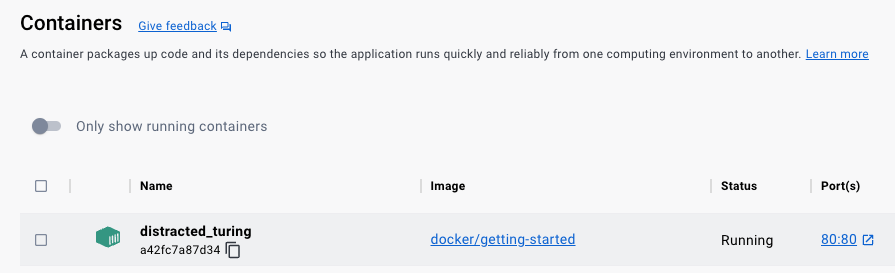

```
import os
from flask import Flask 

app = Flask(__name__)

color = os.environ.get('BG_COLOR')

... rest of app code

```

In the app above we have a color that we set by using an environment variable called `BG_COLOR`. We can set the value of this variable when we run the container:

`docker run -e BG_COLOR=blue app_name`

To find environment variables for a running container you can use the `docker inspect` command.

## Docker Images

Suppose we have a Flask application that we want to containerize. We need to create an image for it. To figure out how to create the image, it helps to think about your application like a recipe - what ingredients do we need in order for our app to run. Typically, we need an OS, then we need some libraries and dependencies, an installation of python and python libraries, some source code, and then we'll need to run a web server. So, our steps are:

- Need an OS (Ubuntu)   
- Update apt repo
- Install dependencies using apt  
- Install python libraries using pip  
- Copy source code  
- Run web server using `flask` command

Instead of installing python, we can simply use a base image that already has python "installed", and then build off of it, thanks to the layering approach to images (described in more detail in the next section). 

A basic Dockerfile for the above instructions might look like:

```
FROM python:3

WORKDIR /src

RUN pip install flask
RUN pip install flask-mysql

COPY . /src

ENTRYPOINT FLASK_APP=src/app.py flask run
```

We could then build the image using:

`docker build -t simple-app .`

Every docker image must be based on another image, all Dockerfiles must start with a `FROM` instruction, specifying a base OS or another image to build off of. The `COPY` instruction will copy what is in the current folder (`.`) to the folder `src/` in the docker container. The `ENTRYPOINT` is used to specify the command that will be run when the container is run. Note that `CMD` can be used as well. There are some differences between `ENTRYPOINT` and `CMD` that we won't be going over right now.



### Layering

Docker images are built in layers. Essentially, we can think of each line of a Dockerfile as adding a new layer to the image. Using our example above, the first layer is the base Ubuntu layer, the second layer is the update of apt-get, the third layer is the installation of python, and so on. Layering is important because if there is a change to the Dockerfile, for example we add a `RUN pip install mlflow` after our `RUN pip install flask-mysql`, when we rebuild the image, the image does not have to be rebuilt from scratch (starting at `FROM python:3`). Instead, only the layers that occur *after* our install of mlflow will need to be rebuilt. 

Note that we can take a look at the layers of an image using `docker image history <image name>`. Use the `--no-trunc` flag to get the untruncated output.



## Data and Volumes

Anything that happens inside of a container will not affect the image. The image itself is read-only. So that means that if we are inside of a container, and we create data, or if we edited the codebase, that data and those edits only exist within that single container, and no other running containers based off of the same image would be affected. Once the container is removed, the data, and edits, are now gone forever.

However, we mentioned earlier that we can persist data by mounting an external volume inside the docker container when we run the container using the `-v` argument. This means that we might have, for example, a folder on our laptop that we'd like to use to save data that is created in our container. Suppose we created a volume on our laptop by running the following:

`docker volume create sql_volume`

Then, when we run a container, we can mount that volume to a folder within the container:

`docker run -v sql_volume:/var/lib/mysql mysql`

The above line maps `sql_volume` to the `/var/lib/mysql/` folder within the `mysql` container. What we've just done is called *volume mounting*, where we've mounted a docker *volume*, which is really just a folder. If, instead, we want to mount a different directory on our docker host (i.e. our laptop) that is not specifically a docker volume, this is called *bind mounting*. 

Rather than use `-v` we should use the more explicit `--mount`, which has `type`, `source`, and `target` parameters that we must specify. For example,

`docker run --mount type=bind,source=/local_dir/data,target=/var/lib/mysql mysql`

Note that you can use `--mount` for regular volume mounting as well by setting `type=volume`. Some may prefer this syntax over using `-v`. 

## Connecting Multiple Containers

There are two things to understand about running multiple Docker containers as part of a single application: networking and composing. Our containers need to be able to talk to each other, and so we have to ensure they are on the same network. Containers, by definition, are isolated environments. But applications are often made up of many moving parts, and rather than stuff an entire application into a single container, it often makes more sense to keep our containers small, which means we have to somehow connect them to each other for the application to run correctly.

Networking is easy in Docker. The rule is, if containers are on the same network, they can talk to each other. I would suggest going through the Multi-Container Apps section of the tutorial that we ran earlier.

When we have an application that relies on multiple containers to run, it does not make sense to run each container line-by-line in a terminal. To simplify the process, we can use something called Docker Compose. With Docker Compose a yaml file is used in order to define which containers should be run, their networks, and ports, etc.. If you'd like to practice this, I'd suggest going to the Using Docker Compose section in the tutorial.

## Docker Registry  

[Docker Hub](https://hub.docker.com/) is the default Docker registry, though there others. Docker registries are how we share our docker images, and where we get images from. It is not required, but we could go on Docker Hub and set up an account so that we can share our images. I will skip this step. 

---

# Container Orchestration

Running a single container is not very useful, we need an orchestration engine that can automatically scale up, scale down, balance the load, and essentially abstract away the underlying infrastructure. This is where Kubernetes (K8s) comes in handy. Note, Docker Swarm and Mesos are altervatives to K8s, but K8s is more popular and so we will be learning some of the very basics of K8s in this demo.



## Terminology

A K8s cluster consists of several parts, but we will only learn about a few. 

*Nodes* are physical machines, or VMs, in which our applications run. If one node goes down, there are other nodes available running the application, so that our whole system doesn't go down. 

Within the nodes are the *pods*. Pods are the smallest deployable compute unit in K8s, but we can think of them as if they are similar to containers. Within a pod there are one or more *containers*, most likely Docker containers, that work together to form an application. The containers within a pod share the same network and compute resources. Each pod has a unique IP address, and the containers within the pod share the same volumes, port space, and inter-process communication (IPC) namespace. Note that pods can be defined using a yaml file, called a manifest.

*Deployments* are instructions, in a yaml file, to K8s on how to deploy an application on the K8s cluster, not to be confused with *model deployments*. A Deployment is defined in the Control Plane (kind of like the cluster manager), and defines how the applications will run on the nodes in the cluster. If a node goes down, the Deployment controller will create a new instance on another node.

*Kubectl* is the K8s CLI.

The *Control Plane* is a server that manages the nodes and pods in the K8s cluster. 

*Kubelet* is a K8s process that manages communication between the control plane and the node, and runs within the node.  

*Docker* is also running in each node, which is needed for pulling images and running containers within the pods.  

A K8s *Service* is the entry point to a set of pods. The Service, defined by a yaml file, defines a coupling between dependent pods. To identify which pods to be targeted by a Service, K8s uses *Labels*. In a pod's manifest, we can give the pod a label so that the Service knows which pods to target. There are different *types* of Services, such as 

- **ClusterIP**   
- **LoadBalancer**  
- **NodePort**  
- **ExternalName**

We don't need to know the details of each one of these right now (or maybe ever). Just note that we can use a *LabelSelector* in the Service yaml file to target our pods with these Services, and it is these Services that keep our applications running if pods die. 



## Installation and Tutorial

Let's go ahead and install Minikube and run through some of the tutorials ourselves on our local machines. Check [here](https://minikube.sigs.k8s.io/docs/start/) for instructions on installing Minikube. Note that you should have Docker installed on your laptop as well. 

Once you have Minikube installed, you will also need to install kubectl, directions which you can find [here](https://kubernetes.io/docs/tasks/tools/#kubectl). After you have Minikube and kubectl installed, we can go through the same exercises of **creating a cluster**, **deploying an app**, **exploring the app**, **exposing the app publicly**, and then **scaling the app**.



### Common kubectl Commands

`kubectl` commands are in format of `kubectl action resource`, which means perform the specified `action` on the specified `resource`. Here are some common `kubectl` commands that we will learn by going through the above tutorials:

`kubectl`: show the usage of `kubectl`.  
`kubectl <command> --help`: get help for specific commands.  
`kubectl version`: check that `kubectl` is installed correctly.  
`kubectl cluster-info`: check the cluster details.  
`kubectl get nodes`: get basic information for all nodes.  
`kubectl describe nodes`: get detailed information for all nodes.  
`kubectl get pods`: get basic information for all pods.  
`kubectl describe pods`: get detailed information for all pods.  
`kubectl create deployment <deployment_name> --image=<image_location>`: creates a deployment by finding a node and configuring the cluster to reschedule the instance on a new node if needed.  
`kubectl get deployments`: get information for all deployments.  
`kubectl describe deployment`: get detailed information for deployments.    
`kubectl logs <pod_name>`: get logs for specific pods (and containers).  
`kubectl exec <pod_name> -- <command>`: execute the command in a specific pod.  
`kubectl get services`: get basic information for all services.  
`kubectl expose <deployment_name> --type="<service_type>"`: creates a new service.  
`kubectl get rs`: get the replica sets.  
`kubectl scale <deployment_name> --replicas=<num_replicas>`: create replicas - scale horizontally.    
`kubectl delete <resource> <resource_name>`: delete pods, deployments and services. Use the `--all` option to delete everything.  



### Create a Cluster

On our local machines we can create a cluster by simply running 

`minikube start`

Once your cluster has started you can run `minikube dashboard` to open a Kubernetes dashboard which you can use to explore your cluster.



### Deploy an Application

After you've created the cluster above, you can create a deployment. First, let's see what nodes we have available to us by running:

`kubectl get nodes`

You should only have one node. Now, we'll go ahead and create a deployment called kubernetes-bootcamp, using the image located at the Google Container Registry here: [gcr.io/google-samples/kubernetes-bootcamp:v1](gcr.io/google-samples/kubernetes-bootcamp:v1). This is a docker image that Kubernetes will pull and then run within a Kubernetes pod.

`kubectl create deployment kubernetes-bootcamp --image=gcr.io/google-samples/kubernetes-bootcamp:v1`

If you run `kubectl get deployments` you will see the deployment you just created. Now, we can't actually see this application from outside of the cluster, so we'll need to expose it, which we'll do in a minute. But first, we can explore the application, the pod, the node, and execute some commands on the application container in the next section.



### Explore the Application

If we now run

`kubectl get pods`

we should see one pod, with a name similar to kubernetes-bootcamp, currently running. If we now run

`kubectl describe pods`

we will get even more details about the pod, the container, and the events that have happened so far (pulling the image, building it, running it).

We can take a look at the application in the terminal by opening a new terminal and running a proxy using 

`kubectl proxy`. 

Then, in a differnt terminal, we need to grab the pod name, and for simplicity we'll set an environment variable to it:

```
export POD_NAME="$(kubectl get pods -o go-template --template '{{range .items}}{{.metadata.name}}{{"\n"}}{{end}}')"
echo Name of the Pod: $POD_NAME
```

From here, we can do a few things. We can see output of our application using curl:

`curl http://localhost:8001/api/v1/namespaces/default/pods/$POD_NAME/proxy/`

We can look at the logs:

`kubectl logs "$POD_NAME"`

And lastly we can execute some commands inside the container, similar to how we did with Docker, using `kubectl exec`. For example:

`kubectl exec "$POD_NAME" -- env`: will list the environment variables

Note that in the above commands we did not have to specify the actual container, only the pod name, because we only have **one** container in the pod.

Next we can actually see the application is running by starting a bash session within the container using:

`kubectl exec -ti $POD_NAME -- bash`

and then using curl:

`curl http://localhost:8080`



### Exposing the Application

There is a concept in Kubernetes called Services. From the Kubernetes documentation, "a Service in Kubernetes is an abstraction which defines a logical set of Pods and a policy by which to access them. Services enable a loose coupling between dependent Pods." The whole point is that Pods are only visible within the cluster, and if you want to expose your application outside of the cluster, you can create a Service. We'll only look at one type of Service, the *NodePort* Service. This will allow us to see our very simple application we deployed from outside of the cluster, rather than having to run `kubectl exec` commands to see it from inside the cluster.

First we just need to create the Service:

`kubectl expose deployment/kubernetes-bootcamp --type="NodePort" --port 8080`

We used `kubectl expose`, defined the type of Service, and also set the port. We can see that our Service is running using 

`kubectl get services`

Now that our Service was created, we have two simple ways to see our application is running from outside the cluster. First, we'll use minikube. Second, we'll use kubectl.

If we run 

`minikube service kubernetes-bootcamp`

it should open up a browser window for you and you'll see the same output that you saw in the terminal when you ran `curl http://localhost:8080`. For the second method, we can forward the port so that we can just open up a browser window ourselves:

```
kubectl port-forward service/kubernetes-bootcamp 7080:8080
http://localhost:7080/
```

There is another concept, called Labels, that I won't be going into, but feel free to read more about it in the Kubernetes docs.



### Scaling the Application

We will quickly show here how we can scale by simply replicating our pods. This is horizontal scaling. First, if we run `kubectl get pods` you should see only **one** pod. We can double-check this by running `kubectl get rs` which will give us details of something called the ReplicaSet, which will confirm we have one pod. Let's create **5** replicas by running

`kubectl scale deployments/kubernetes-bootcamp --replicas=5`

Now, we can simply run `kubectl get deployments` and `kubectl get rs` to confirm we have 5 instances of our application available. Also we can see from `kubectl get pods -o wide` the 5 pods and their IP addresses and the node they are running on (it should be just one single node).

You can scale down and destroy pods by running the same command above, but with fewer replicas.

```
kubectl scale deployments/kubernetes-bootcamp --replicas=2
kubectl get pods -o wide
```



### Kubernetes Recap

Now that we understand, from a high level, what K8s is and what it is trying to do, and we've had a chance to practice with some `kubectl` commands, we will be able to potentially scale out our model development and deployment using K8s on GCP (also called GKE for Google Kubernetes Engine). But, before we get around to trying to deploy GKE, and other services, in GCP, we should also learn a bit about one more topic, infrastructure-as-code, which we will do in a future lecture.

---

# Containerization and Orchestration Lab (local)

## Overview

In this lab we will get mlflow running in a container, and then also in kubernetes, locally on our laptops.

## Goal

The goal of this lab is to get a little practice with creating Docker images and running containers, and then deploying those images in a kubernetes cluster on our laptops using minikube and kubectl.

## Instructions

### Turning It In

**IMPORTANT: read this before you go through the steps below.**

To show that you've gone through this lab successfully, I want you to take several snapshots of your progress. I will point out below when to take a snapshot, and what to take a snapshot of. Then combine all snapshots into a word document, export as pdf, and **submit the pdf to Canvas**.

### Containerization 

We first need to create a Docker image for mlflow so that we can get the mlflow server running inside a container. To do this we can either use a pre-built image for mlflow, if one exists, or we can create the image ourselves by writing a Dockerfile. I suggest we write a Dockerfile and keep it simple.  

Steps:
- Create a new folder called `mlflow_test`.  
- Create a Dockerfile and save it in the `mlflow_test/` folder.  
- Build the image and **take a snapshot of the output in the terminal**.   
- Run the container.  
- Access the server at `http://localhost:5000` and **take a snapshot of the mlflow server ui along with the address bar to show the URL**.   
- Stop the container.

We should start the Dockerfile with a base image that contains python in it, and we should end with a call to mlflow server. We never actually ran the mlflow server command, but what it does is launch the mlflow server. We should use `mlflow server --host 0.0.0.0 --port 5000`. Feel free to use AI assistance to create the Dockerfile.

### Orchestration  

After you confirm that the container can run on your laptop, let's use minikube to spin up a one-node kubernetes cluster and then run the container on the cluster. For this we will need to do several high-level steps:

- Start minikube.  
- Push the image to minikube.  
- Create a deployment and service for mlflow so that the mlflow container you created will run in minikube.  
- Access mlflow server that is running in minikube.  
- Connect our local python notebook to mlflow server in minikube.  

To do this successfully we will need to create two yaml files, one that defines the deployment (what's the image we want to deploy and how many replicas do we want), and one that defines the service (how can we access this deployment from our laptop). Let's go through this step-by-step.

Steps:
1. Start minikube and dashboard.  

2. To push the image to minikube, we can build it in minikube rather than on our laptop. To run docker commands in minikube, you first need to run

`eval $(minikube docker-env)`

then any docker commands you run after this will occur in minikube. Build the image and make sure it's there. When you are done running docker commands in minikube, you can switch back to your local by running

`eval $(minikube docker-env --unset)`  

3. Create mlflow-deployment.yaml and mlflow-service.yaml. I will provide a version of these for you, but you should look at them at least, or ask your favorite LLM tool to create one and walk you through it.  

4. Apply the deployment and services to your minikube cluster by running 

`kubectl apply -f mlflow-deployment.yaml`  
`kubectl apply -f mlflow-service.yaml`  

**Take three snapshots of the minikube dashboard: (1) Deployments; (2) Pods; (3) Services**   

5. Now you can access the application by running  

`minikube service mlflow-service`  

This should open up the mlflow server in a browser. **Take a snapshot of the UI with the address bar to show the URL.**     

6. Scale up by increasing the number of replicas, **take a snapshot of the dashboard Pods page showing that multiple pods were created**, then scale back down.  

7. In order to connect our python notebook to the mlflow server now running in minikube we need to set up port forwarding. We need to get the name of the mlflow service by running the first command below (which should just be mlflow-server), and then run the second command, maybe in a new terminal so you can keep it running.

`kubectl get services`  
`kubectl port-forward service/mlflow-service 5000:5000`

8. Make a copy of your Lab 2 notebook, and change the tracking URI by using `mlflow.set_tracking_uri('http://127.0.0.1:5000')` instead of `mlflow.set_tracking_uri('sqlite:///mlflow.db')`. Now, when you run the code it should be getting logged in minikube. Run all of the code cells up to, and including, the first experiment run (the first cell that starts with `mlflow.start_run():`). **Take a snapshot of the mlflow server UI and the address bar to show that the experiment was logged in the minikube mlflow server**.



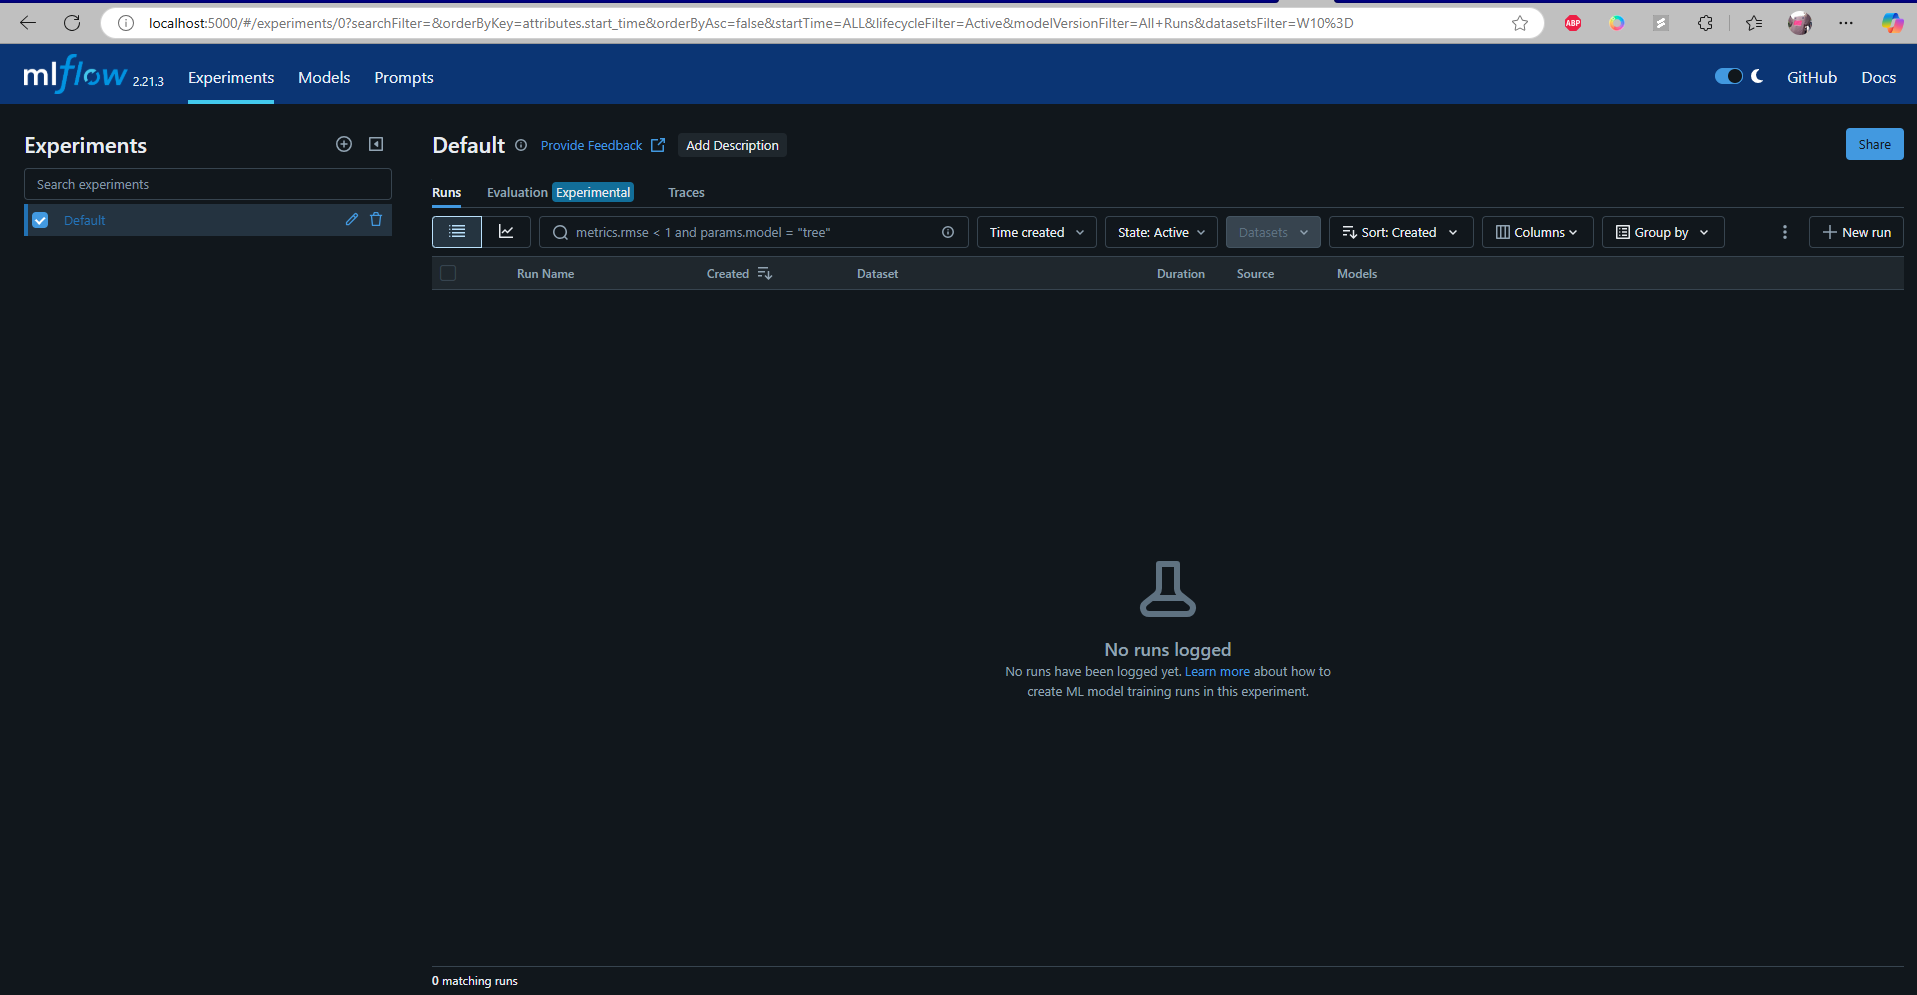

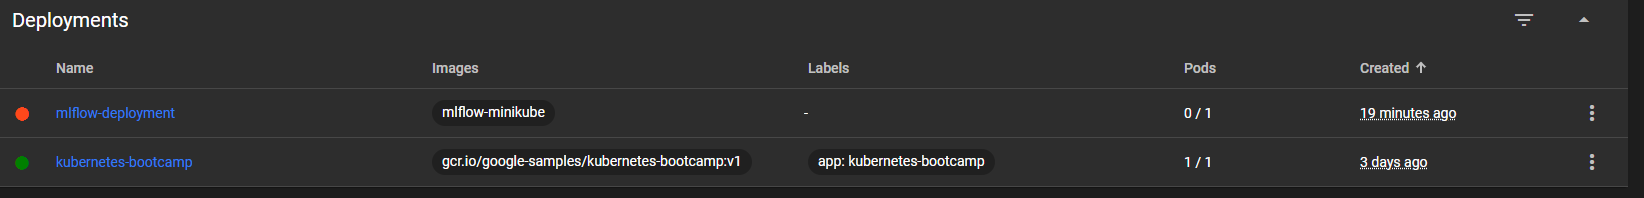

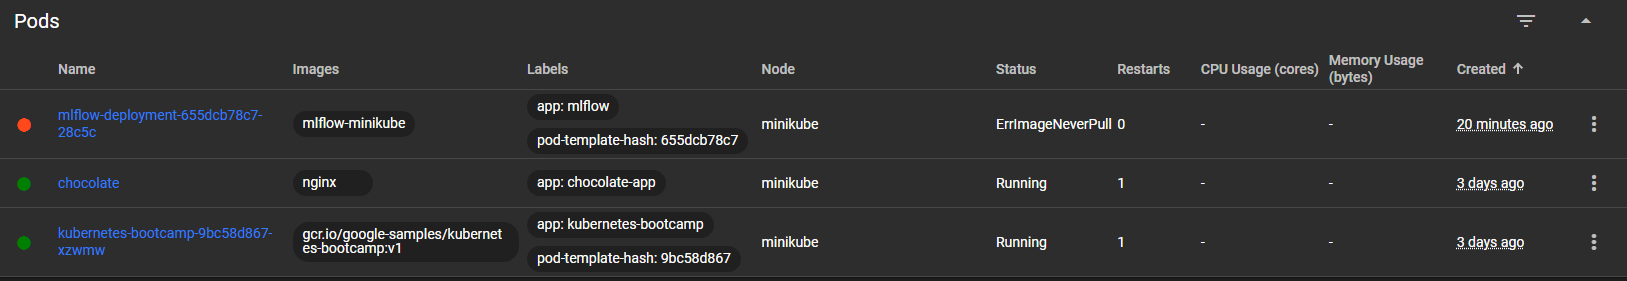

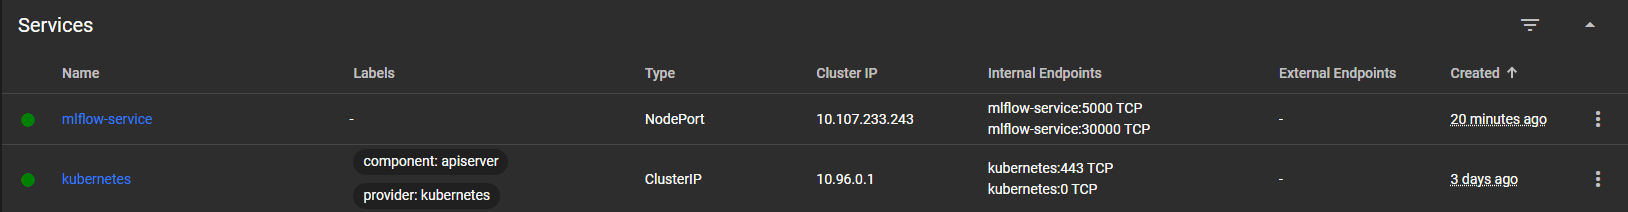

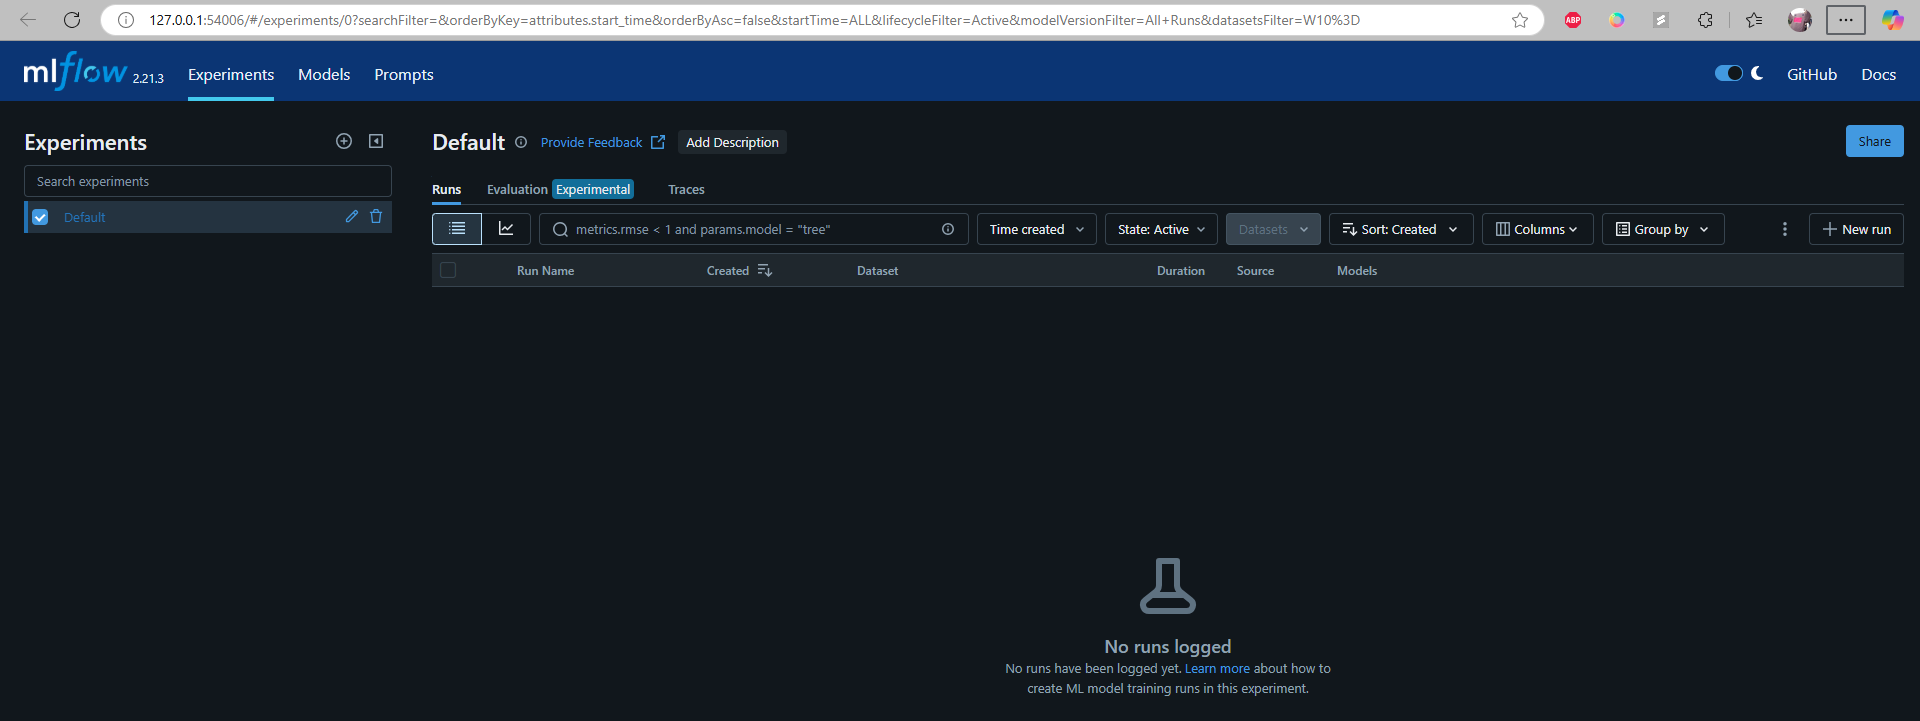

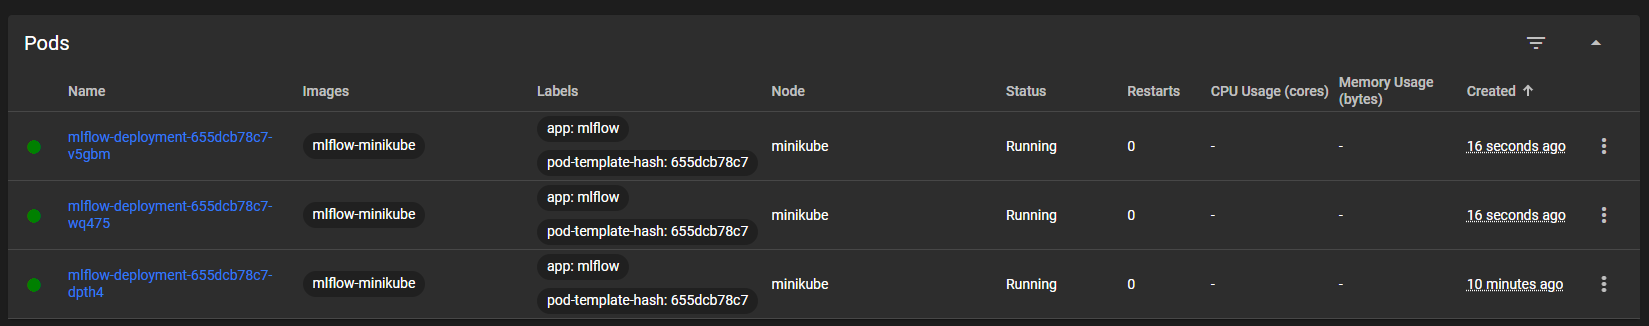

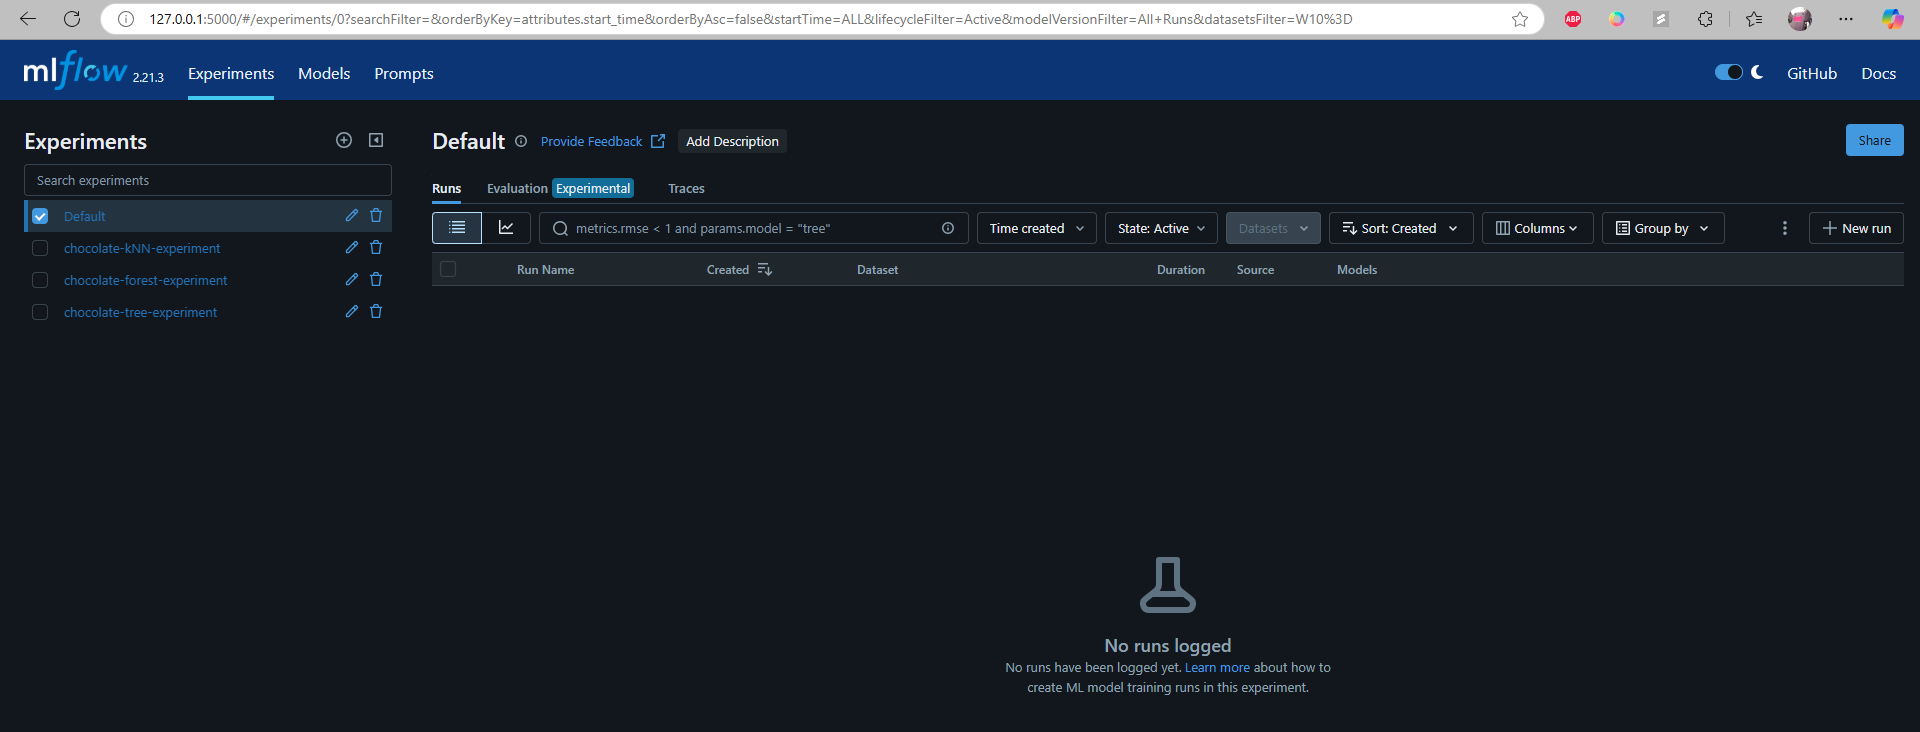